In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t
from arch import arch_model

## This Notebook Aims to display how we calculate the VaR($\Delta$ BOF)

In [41]:
def fetch_data_df():
    df = pd.read_csv('../../data/final_asset_classes.csv', index_col=0, parse_dates=True)
    df.index = pd.to_datetime(df.index)
    #df = df.iloc[:, :6]
    return df

In [42]:
df = fetch_data_df()

In [43]:
df.shape

(4978, 7)

In [44]:
df.head()

,MSCI,FTSEREEL,FTSECORP,PE,FTSEGOV,FTWBIGUSDT,FTSECORPALT
Date,,,,,,,
2005-10-10,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2005-10-11,1.007047,1.003231,0.998340,1.006833,0.998084,1.003503,1.000831
2005-10-12,0.999229,0.999670,0.996919,0.997110,0.996517,1.000279,0.999572
2005-10-13,0.991452,0.981077,0.994239,0.986449,0.993465,0.993882,0.988554
2005-10-14,0.995770,0.973370,0.994292,0.987997,0.993525,0.995137,0.995903


In [45]:
returns_df = df.pct_change(fill_method=None).dropna()
returns_df.head()

,MSCI,FTSEREEL,FTSECORP,PE,FTSEGOV,FTWBIGUSDT,FTSECORPALT
Date,,,,,,,
2005-10-11,0.007047,0.003231,-0.001660,0.006833,-0.001916,0.003503,0.000831
2005-10-12,-0.007763,-0.003550,-0.001424,-0.009657,-0.001570,-0.003213,-0.001258
2005-10-13,-0.007783,-0.018599,-0.002688,-0.010692,-0.003062,-0.006395,-0.011023
2005-10-14,0.004355,-0.007856,0.000053,0.001569,0.000060,0.001263,0.007433
2005-10-17,0.004154,-0.003613,-0.000232,0.000492,-0.000227,0.001848,0.000639


In [46]:
returns_df.shape

(4634, 7)

## Creating Three different distributions for VaR($\Delta$ BoF)
Done by doing Monte Carlo Simulations
1. Assume normal distribution
2. Assume t-student
3. Use GARCH

**Paramters**

In [47]:
assets_0 = 1000000
liabilities_0 = assets_0 * 0.6
liability_growth = 0.03

weights = np.array([0.0, 0.8, 0.1, 0.095, 0.0, 0.025, 0.025]) 

n_simulations = 100000
n_days = 252  # 1 year is typically 252 trading days

asset_classes = df.columns

### Assuming normal

In [48]:
mean_returns = returns_df.mean()
cov_matrix = returns_df.cov()

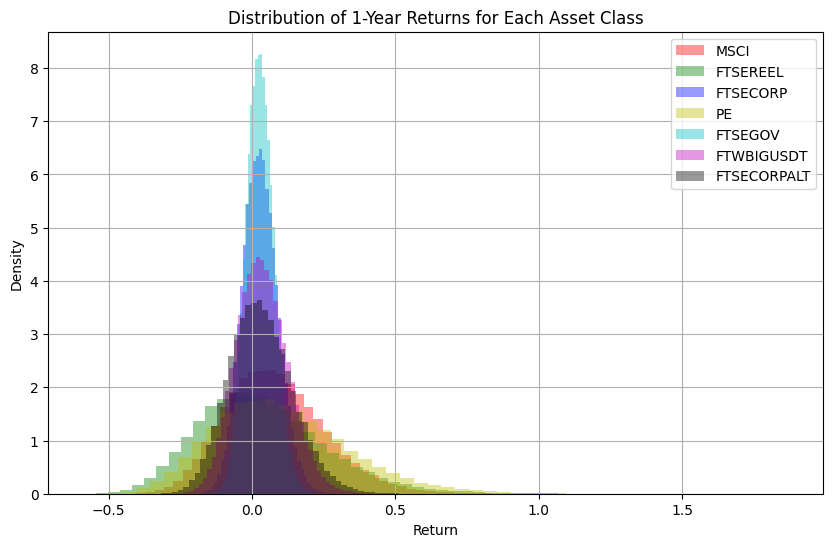

In [49]:
# Simulate daily returns for 1 year using the multivariate normal distribution
simulated_daily_returns = np.random.multivariate_normal(mean_returns, cov_matrix, (n_simulations, n_days))

# Calculate cumulative returns for each asset class over 1 year
simulated_cumulative_returns = np.cumprod(1 + simulated_daily_returns, axis=1)[:, -1] - 1

plt.figure(figsize=(10, 6))

colors = ['r', 'g', 'b', 'y', 'c', 'm', "k"]  # Colors for each asset class (adjust to match the number of assets)

for i, asset_class in enumerate(asset_classes):
    plt.hist(simulated_cumulative_returns[:, i], bins=50, alpha=0.4, color=colors[i], label=asset_class, density=True)

plt.title('Distribution of 1-Year Returns for Each Asset Class')
plt.xlabel('Return')
plt.ylabel('Density')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()


Now make same plot but for basic own funds

In [50]:
def plot_BOF_distribution(simulated_daily_returns):
    BOF_0 = assets_0 - liabilities_0  

    portfolio_returns = np.dot(simulated_daily_returns, weights) 
    simulated_cumulative_returns = np.cumprod(1 + portfolio_returns, axis=1)[:, -1] - 1

    assets_t1 = assets_0 * (1 + simulated_cumulative_returns)  # Assets after 1 year
    liabilities_t1 = liabilities_0 * (1 + liability_growth)  # Liabilities after 1 year

    bof_t1 = assets_t1 - liabilities_t1
    bof_change = bof_t1 - BOF_0

    scr = np.percentile(bof_change, 100 * (1 - 0.995))

    plt.figure(figsize=(10, 6))
    plt.hist(bof_change / 1e6, bins=500, alpha=0.7, color='c', label='Change in BOF Distribution', density=True)
    plt.axvline(np.percentile(bof_change, 0.5) / 1e6, color='r', linestyle='--', label='VaR (alpha=0.995)')
    plt.title('Distribution of Change in BOF after 1 Year: Monte Carlo')
    plt.xlabel('Change in BOF (Millions)')
    plt.ylabel('Density')
    
    plt.xlim(-2, 2)
    plt.xticks(np.arange(-2, 2.5, 0.5))  # Increments of 0.5 within the range [-2, 2]

    plt.legend()
    plt.grid(True)
    plt.show()



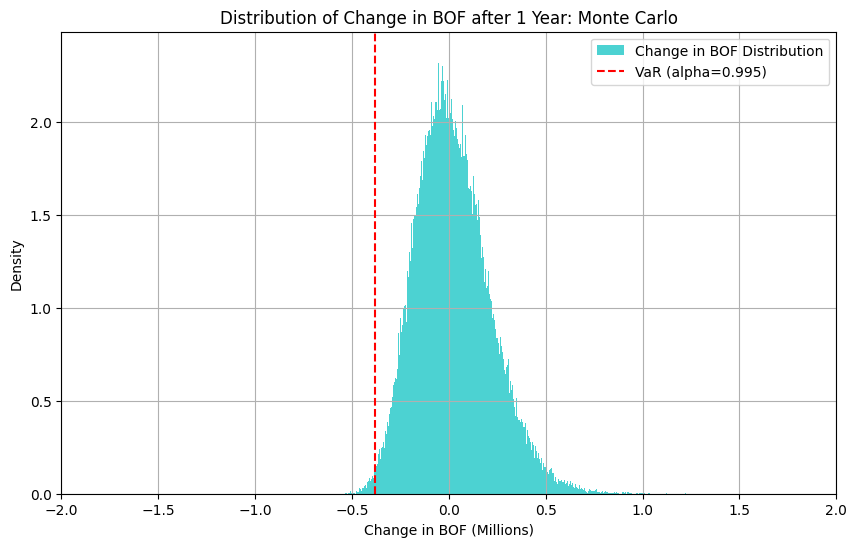

In [51]:
plot_BOF_distribution(simulated_daily_returns)

## Assuming t-student

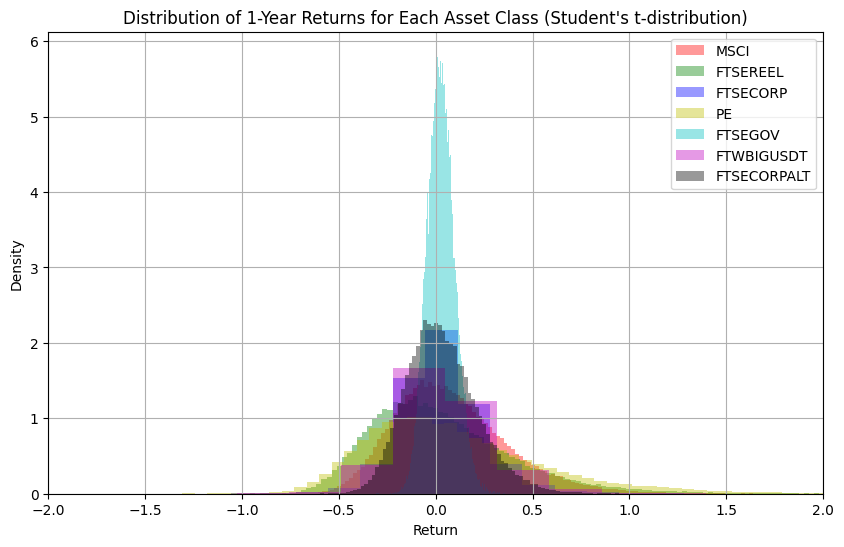

In [52]:
# Fit a t-distribution to each asset's daily returns to estimate degrees of freedom, mean, and scale
t_params = [t.fit(returns_df[col].dropna()) for col in returns_df.columns]
df_degrees = [params[0] for params in t_params]  # Extract degrees of freedom for each asset

# Initialize an array to store simulated daily returns for all assets
simulated_daily_returns = np.zeros((n_simulations, n_days, len(mean_returns)))

# Generate daily returns for each asset using the t-distribution
for i, (mean, std, df) in enumerate(zip(mean_returns, np.sqrt(np.diag(cov_matrix)), df_degrees)):
    simulated_daily_returns[:, :, i] = t.rvs(df, loc=mean, scale=std, size=(n_simulations, n_days))

# Calculate cumulative returns over 1 year for each simulation and asset
simulated_cumulative_returns = np.cumprod(1 + simulated_daily_returns, axis=1)[:, -1, :] - 1

# Plot the distribution of 1-year returns for each asset
plt.figure(figsize=(10, 6))
colors = ['r', 'g', 'b', 'y', 'c', 'm', "k"]  # Colors for each asset class

for i, asset_class in enumerate(returns_df.columns):
    plt.hist(
        simulated_cumulative_returns[:, i],
        bins=500,
        alpha=0.4,
        color=colors[i % len(colors)],
        label=asset_class,
        density=True
    )

plt.title('Distribution of 1-Year Returns for Each Asset Class (Student\'s t-distribution)')
plt.xlabel('Return')
plt.ylabel('Density')

# Adjust x-axis limits to broaden the view
plt.xlim(-2, 2)  # Adjust as necessary to provide a wider view

plt.grid(True)
plt.legend(loc='upper right')
plt.show()


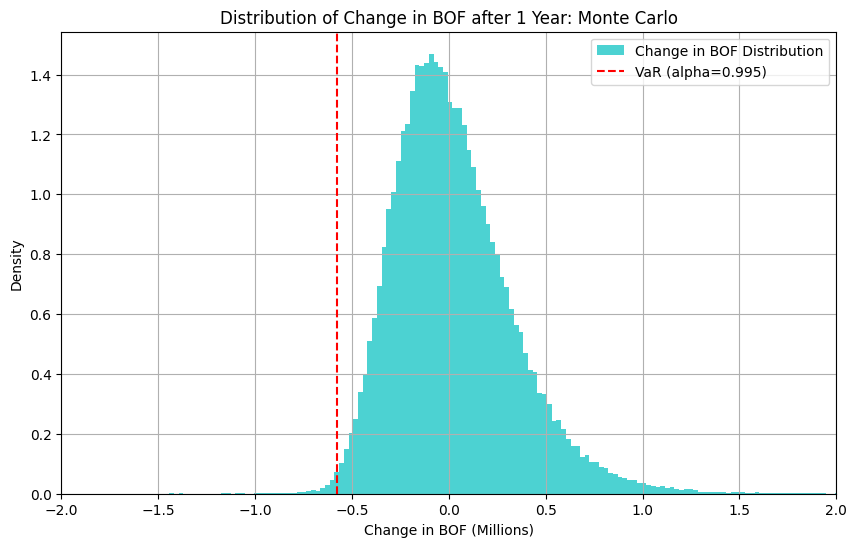

In [53]:
plot_BOF_distribution(simulated_daily_returns)

## Using GARCH

In [54]:
n_simulations = 1000

Testing out GARCH

In [55]:
asset_returns_scaled = returns_df * 100

for asset in asset_returns_scaled.columns:
    asset_returns = asset_returns_scaled[asset].dropna()  # Replace with an actual column name

    # Step 1: Fit the GJR-GARCH(1,1) model
    gjr_garch_model = arch_model(asset_returns, vol='Garch', p=1, o=1, q=1, dist='t', rescale=False)
    model_fit = gjr_garch_model.fit(disp="off", options={'maxiter': 1000}) 

    # Display the model summary
    print(model_fit.summary())

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                         MSCI   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -5500.26
Distribution:      Standardized Student's t   AIC:                           11012.5
Method:                  Maximum Likelihood   BIC:                           11051.2
                                              No. Observations:                 4634
Date:                      Thu, Nov 07 2024   Df Residuals:                     4633
Time:                              21:38:03   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

In [56]:
simulated_daily_returns = np.zeros((n_simulations, n_days, len(returns_df.columns)))

asset_returns_scaled = returns_df * 100

# Iterate over each asset and simulate returns
for i, asset in enumerate(asset_returns_scaled.columns):
    print(f"Processing {asset}...")
    asset_returns = asset_returns_scaled[asset].dropna()

    # Fit GJR-GARCH(1,1) model
    garch_model = arch_model(asset_returns, vol='Garch', p=1, o=1, q=1, dist='t', rescale=False)
    model_fit = garch_model.fit(disp="off", options={'maxiter': 1000})

    # Retrieve model parameters for simulation
    omega = model_fit.params['omega']
    alpha = model_fit.params.get('alpha[1]', 0)
    gamma = model_fit.params.get('gamma[1]', 0)
    beta = model_fit.params['beta[1]']
    nu = model_fit.params['nu']  # Degrees of freedom for Student's t

    # Initialize conditional variance
    sigma2_t = model_fit.conditional_volatility[-1] ** 2  # Start with last observed variance

    # Generate simulated paths
    for sim in range(n_simulations):
        simulated_path = []
        
        for day in range(n_days):
            # Generate a random shock from a standardized Student's t distribution
            shock = np.random.standard_t(nu)
            
            # Calculate today's return based on the conditional volatility
            return_t = np.sqrt(sigma2_t) * shock
            
            # Append simulated return to the path
            simulated_path.append(return_t)
            
            # Update conditional variance for the next day
            sigma2_t = model_fit.conditional_volatility.iloc[-1] ** 2
        
        # Store the simulated path for this asset and simulation
        simulated_daily_returns[sim, :, i] = simulated_path

Processing MSCI...


/var/folders/h4/_4wngf5n4793mylk022tqrrh0000gn/T/ipykernel_41925/2637994646.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sigma2_t = model_fit.conditional_volatility[-1] ** 2  # Start with last observed variance


Processing FTSEREEL...


/var/folders/h4/_4wngf5n4793mylk022tqrrh0000gn/T/ipykernel_41925/2637994646.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sigma2_t = model_fit.conditional_volatility[-1] ** 2  # Start with last observed variance


Processing FTSECORP...


/var/folders/h4/_4wngf5n4793mylk022tqrrh0000gn/T/ipykernel_41925/2637994646.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sigma2_t = model_fit.conditional_volatility[-1] ** 2  # Start with last observed variance


Processing PE...


/var/folders/h4/_4wngf5n4793mylk022tqrrh0000gn/T/ipykernel_41925/2637994646.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sigma2_t = model_fit.conditional_volatility[-1] ** 2  # Start with last observed variance


Processing FTSEGOV...


/var/folders/h4/_4wngf5n4793mylk022tqrrh0000gn/T/ipykernel_41925/2637994646.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sigma2_t = model_fit.conditional_volatility[-1] ** 2  # Start with last observed variance


Processing FTWBIGUSDT...


/var/folders/h4/_4wngf5n4793mylk022tqrrh0000gn/T/ipykernel_41925/2637994646.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sigma2_t = model_fit.conditional_volatility[-1] ** 2  # Start with last observed variance


Processing FTSECORPALT...


/var/folders/h4/_4wngf5n4793mylk022tqrrh0000gn/T/ipykernel_41925/2637994646.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sigma2_t = model_fit.conditional_volatility[-1] ** 2  # Start with last observed variance


In [57]:
simulated_cumulative_returns = np.cumprod(1 + simulated_daily_returns, axis=1) - 1


In [58]:
simulated_cumulative_returns.shape

(1000, 252, 7)

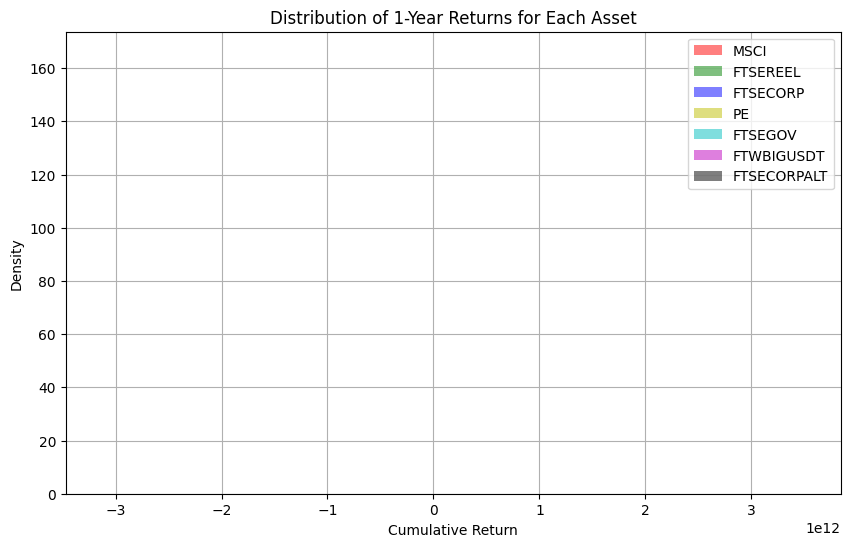

In [59]:
plt.figure(figsize=(10, 6))
colors = ['r', 'g', 'b', 'y', 'c', 'm', 'k']

# Loop through each asset and plot the 1-year cumulative return distribution
for i, asset in enumerate(returns_df.columns):
    plt.hist(
        simulated_cumulative_returns[:, -1, i],  # Use the last day of cumulative returns for each asset
        bins=50,
        alpha=0.5,
        color=colors[i % len(colors)],  # Assign each asset a color
        label=asset,
        density=True
    )

# Formatting the plot
plt.title('Distribution of 1-Year Returns for Each Asset')
plt.xlabel('Cumulative Return')
plt.ylabel('Density')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()



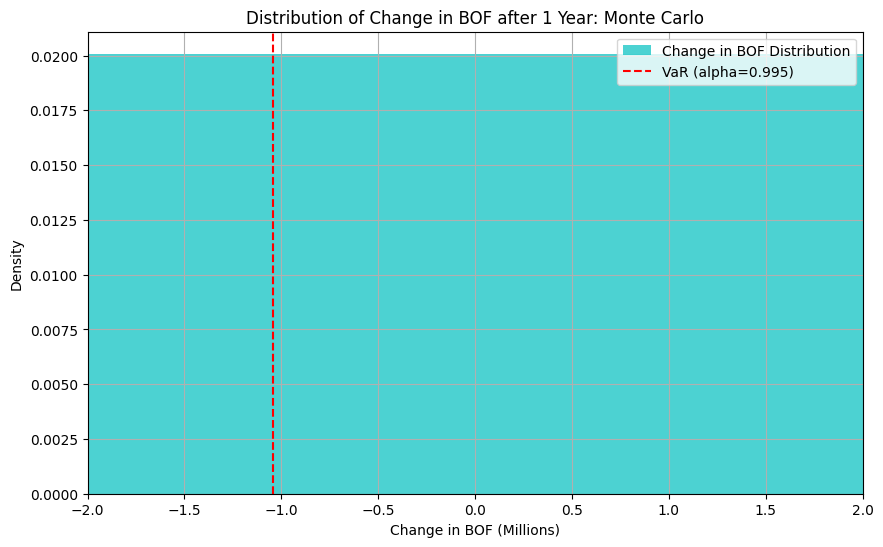

In [60]:
plot_BOF_distribution(simulated_daily_returns)